In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from  scipy.stats  import norm
from scipy.stats import lognorm

from sources.plotter import Plotter
from sources.bivariateMonteCarlo import BivariateMonteCarlo
from sources.bacheliermodel import BachelierModel
from sources.blackscholesmodel import BlackScholes
from sources.distribution_test import DistributionTest

bs = BlackScholes()
bachelier = BachelierModel()
plotter = Plotter()
BMC = BivariateMonteCarlo()
tests = DistributionTest()

# Standard settings:
n_steps = 251
S1_0 = 100 * 11
S2_0 = 100 * 4
n_sim = 100000 #number of simulations
volatility = np.array([0.37, 0.54]) 
daily_volatility = np.sqrt(volatility / n_steps)  # Scale to daily volatility

rho = 0.3
S0 = (S1_0, S2_0)
spread_0 = S1_0 - S2_0
K = spread_0
r = 0.05
T = 1

# Question 1.a: 
Value this option by bivariate Monte Carlo simulations.

In [7]:
stock_simulations = BMC.simulate_bivariate_monte_carlo(S0, daily_volatility, rho=rho, n_steps=n_steps, n_sim=n_sim)
option_price, payoffs, spread = BMC.monte_carlo_option_price(stock_simulations[0], stock_simulations[1], T, r, K)
n = np.size(payoffs)
std_error = np.std(payoffs, ddof=1) / np.sqrt(n)

print(f'The call option price: {option_price}')
print(f'Standard deviation: {std_error}')

# tests.plot_lognormaldistribution(spread)  
# plotter.plot_stocks(stock_simulations, n_sim=100)
# tests.run_Anderson_Darling_test(spread)

The call option price: 231.0273055588982
Standard deviation: 1.6288113223427774


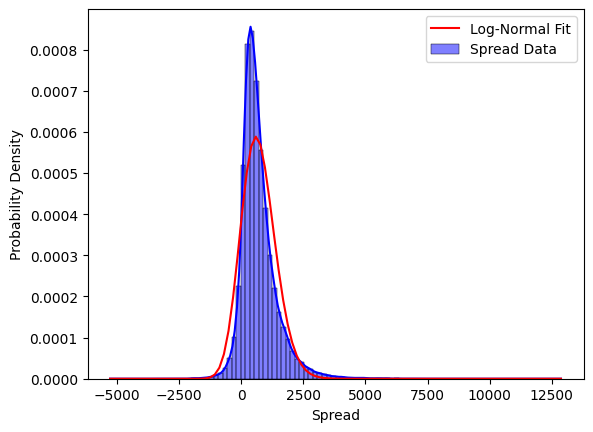

In [11]:
tests.plot_lognormaldistribution(spread)  

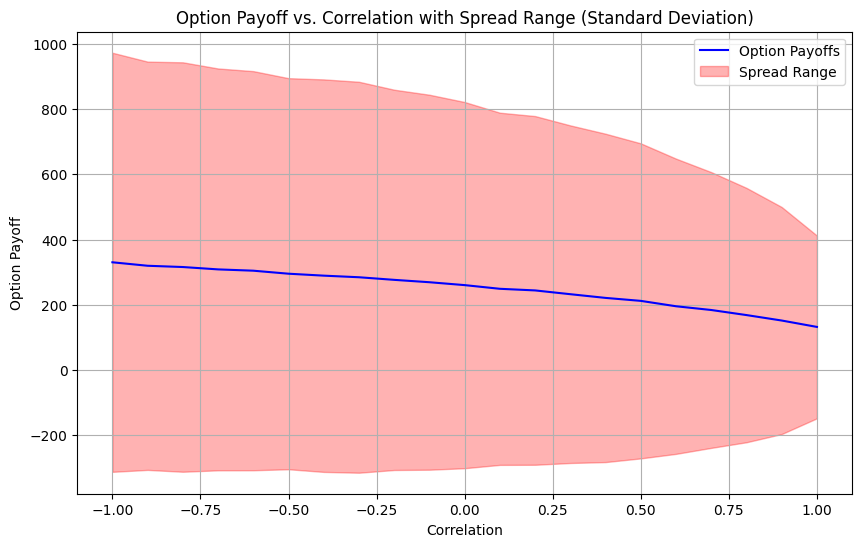

In [22]:
corr_range = np.linspace(-1, 1, 21)
option_price_list = []
spread_list = []

for cor in corr_range: 
    stock_simulations = BMC.simulate_bivariate_monte_carlo(S0, daily_volatility, rho=cor, n_steps=n_steps, n_sim=10000)
    option_price, payoffs, spread = BMC.monte_carlo_option_price(stock_simulations[0], stock_simulations[1], T, r, K)
    option_price_list.append(option_price)
    spread_list.append(np.std(payoffs))


plotter.plot_diffcorrelation_payoffs(option_price_list, corr_range, spread_list)

# Question 1C: 

In [36]:
# Portfolio variance of the spread: 

portfolio_variance_annual = BMC.calculate_spread_volatility(volatility[0], volatility[1], rho=0.3)
portfolio_variance_daily = BMC.calculate_spread_volatility(daily_volatility[0], daily_volatility[1], rho=0.3)

print(f"For daily spread volatility, we have {np.round(portfolio_variance_daily*100,2)}% and annual volatility  we have {np.round(portfolio_variance_annual*100,2)}%")

For daily spread volatility, we have 5.06% and annual volatility  we have 55.55%


In [307]:
# Calculate Bachelier volatility on daily and yearly basis
bachelier_volatility_daily = bachelier.daily_volatility_bachelier(S0, daily_volatility, rho)
bachelier_volatility_yearly = bachelier_volatility_daily * np.sqrt(252)

# Calculate Bachelier option price
bachelier_call_price = bachelier.calculate_bachelier_option_price(spread_0, K, bachelier_volatility_yearly, T, r)

# Calculate GBM volatility on a yearly basis
gbm_volatility_yearly = bachelier_volatility_yearly / spread_0

# Calculate GBM option price using Black-Scholes formula
gbm_price = bs.calc_blackscholes(spread_0, K, gbm_volatility_yearly, T, r)

# Simulate bivariate Monte Carlo for stock prices
stock_simulations = BMC.simulate_bivariate_monte_carlo(S0, daily_volatility, rho=rho, n_steps=n_steps, n_sim=n_sim)

# Calculate option price using Monte Carlo simulation
option_price, payoffs = BMC.monte_carlo_option_price(stock_simulations[0], stock_simulations[1], T, r, K)

# Print all results
print("Bachelier Volatility (Daily):", bachelier_volatility_daily)
print("Bachelier Volatility (Yearly):", bachelier_volatility_yearly)
print("Bachelier Call Price:", bachelier_call_price)
print("GBM Volatility (Yearly):", gbm_volatility_yearly)
print("GBM Option Price:", gbm_price)
print("Monte Carlo Option Price:", option_price)

# Optionally, you can print payoffs as well if needed

Bachelier Volatility (Daily): 40.71544719673941
Bachelier Volatility (Yearly): 646.3376868081265
Bachelier Call Price: 269.790153032099
GBM Volatility (Yearly): 0.9233395525830378
GBM Option Price: 277.2634608525917
Monte Carlo Option Price: 274.413897060741


In [5]:
S0

(1100, 400)

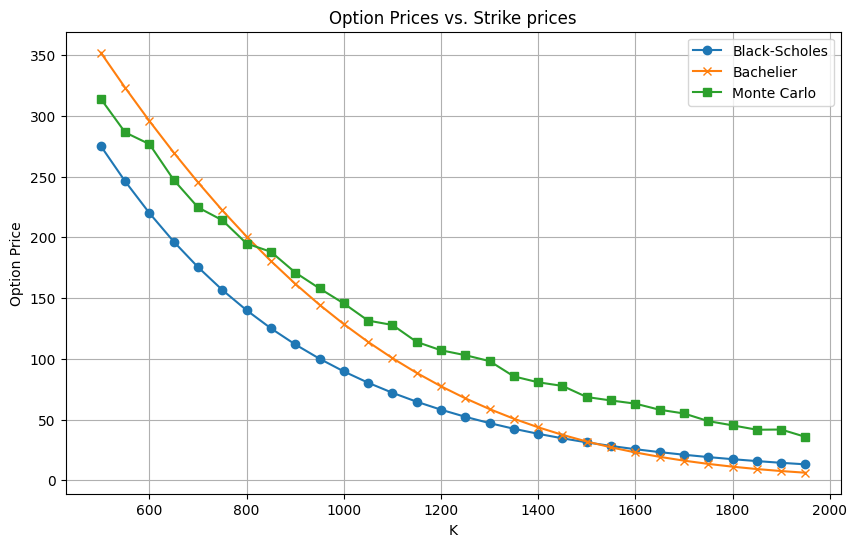

In [30]:
strikeprices = np.arange(500,2000,50)

bs_prices = []
bachelier_prices = []
monte_carlo_prices = []

for strikeprice in strikeprices:
    K = strikeprice
    bachelier_volatility_daily = bachelier.daily_volatility_bachelier(S0, daily_volatility, rho)
    bachelier_volatility_yearly = bachelier_volatility_daily * np.sqrt(252)
    bachelier_call_price = bachelier.calculate_bachelier_option_price(spread_0, K, bachelier_volatility_yearly, T, r )
    
    gbm_volatility_yearly = bachelier_volatility_yearly / S0
    gbm_price = bs.calc_blackscholes(spread_0,K , gbm_volatility_yearly,T,r)

    stock_simulations = BMC.simulate_bivariate_monte_carlo(S0, daily_volatility, rho=rho, n_steps=n_steps, n_sim=10000)
    option_price, payoffs, spread = BMC.monte_carlo_option_price(stock_simulations[0], stock_simulations[1], T, r, K)
    # Append data to lists
    # print(option_price)
    bs_prices.append(gbm_price[0])  # Assuming 'gbm_price' is Black-Scholes price
    bachelier_prices.append(bachelier_call_price)
    monte_carlo_prices.append(option_price)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(strikeprices, bs_prices, label='Black-Scholes', marker='o')
plt.plot(strikeprices, bachelier_prices, label='Bachelier', marker='x')
plt.plot(strikeprices, monte_carlo_prices, label='Monte Carlo', marker='s')

plt.xlabel('K')
plt.ylabel('Option Price')
plt.title('Option Prices vs. Strike prices')
plt.legend()
plt.grid()

plt.show()

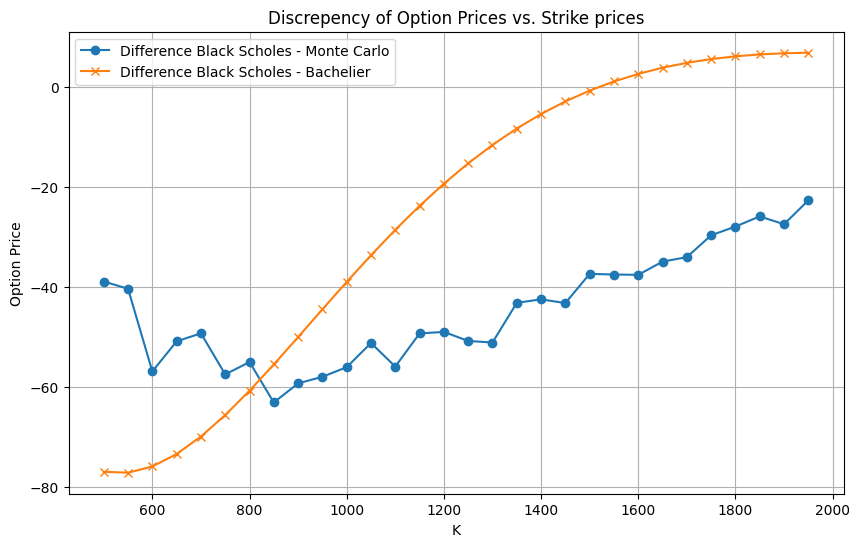

In [40]:
bs_bach_list = []
bs_mc_list = []
for i in range(len(bachelier_prices)):
    dif_bs_bach = bs_prices[i] - bachelier_prices[i]
    dif_bs_mc = bs_prices[i] - monte_carlo_prices[i]
    bs_mc_list.append(dif_bs_mc)
    bs_bach_list.append(dif_bs_bach)

plt.figure(figsize=(10, 6))
plt.plot(strikeprices, bs_mc_list, label='Difference Black Scholes - Monte Carlo', marker='o')
plt.plot(strikeprices, bs_bach_list, label='Difference Black Scholes - Bachelier', marker='x')
# plt.plot(strikeprices, monte_carlo_prices, label='Monte Carlo', marker='s')

plt.xlabel('K')
plt.ylabel('Option Price')
plt.title('Discrepency of Option Prices vs. Strike prices')
plt.legend()
plt.grid()

plt.show()

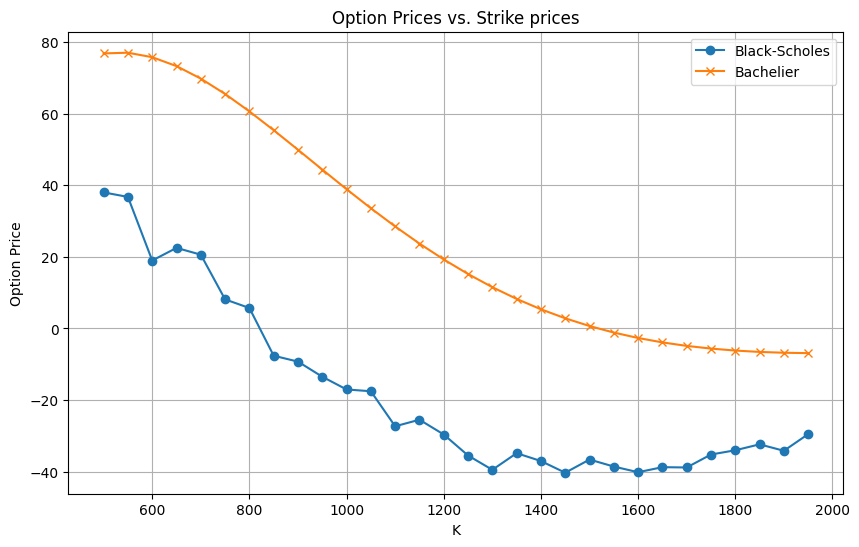